In [2]:
#Read in data

import pandas as pd
import collections as co
import math
import numpy as np
import scipy.sparse as spr
import nltk
from nltk.stem.snowball import SnowballStemmer
from nltk.corpus import stopwords

bios = pd.read_csv("bios.csv", usecols = ["Bio","Label","Year","Name"])

In [3]:
#Clean up
n = bios.shape[0]

bios.Bio = bios.Bio.str.lower()

bios.Name = bios.Name.str.lower()

stemmer = SnowballStemmer("english")

for i in range(n):
    bios.Bio.loc[i] = nltk.word_tokenize(bios.Bio.loc[i])
    bios.Name.loc[i] = nltk.word_tokenize(bios.Name.loc[i])

for i in range(n):
    for j in range(len(bios.Bio.loc[i])):
        bios.Bio.loc[i][j] = stemmer.stem(bios.Bio.loc[i][j])
    
    for j in range(len(bios.Bio.loc[i])):
        bios.Bio.loc[i][j] = bios.Bio.loc[i][j].strip(" .,?!/")
        
    
    if ("dr" in bios.Name.loc[i]):
        bios.Name.loc[i].remove("dr")
    if ("prof" in bios.Name.loc[i]):
        bios.Name.loc[i].remove("prof")
    
    if (bios.Label.loc[i] != 'F') or (bios.Label.loc[i] != 'M'):
        if ('F' in bios.Label.loc[i]):
            bios.loc[i,"Label"] = 'f'
        elif ('M' in bios.Label.loc[i]):
            bios.loc[i,"Label"] = 'm'

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [4]:
#Build dictionary and document vectors
lookup = co.Counter()
stop_words = set(stopwords.words('english'))
index = 0

for i in range(n):
    for j in range(len(bios.Bio.loc[i])):
        if (bios.Bio.loc[i][j] not in stop_words) and (bios.Bio.loc[i][j] not in bios.Name.loc[i]) and (bios.Bio.loc[i][j].isalpha()) and (bios.Bio.loc[i][j] not in lookup):
            lookup[bios.Bio.loc[i][j]] = index
            index += 1

idf = np.zeros(len(lookup))

for i in range(n):
    docflag = lookup.copy()
    for j in range(len(bios.Bio.loc[i])):
        if (bios.Bio.loc[i][j] not in stop_words) and (bios.Bio.loc[i][j] not in bios.Name.loc[i]) and (bios.Bio.loc[i][j].isalpha()):
            if (docflag[bios.Bio.loc[i][j]] > -1):
                idf[lookup[bios.Bio.loc[i][j]]]  += 1
                docflag[bios.Bio.loc[i][j]] = -1
for i in range(len(lookup)):
    idf[i] = math.log(n/idf[i])
    
docvec = []

for i in range(n):
    docvec.append(np.zeros(len(lookup)))
    for j in range(len(bios.Bio.loc[i])):
        if (bios.Bio.loc[i][j] not in stop_words) and (bios.Bio.loc[i][j] not in bios.Name.loc[i]) and (bios.Bio.loc[i][j].isalpha()):
            docvec[i][lookup[bios.Bio.loc[i][j]]] += 1
    docvec[i] = docvec[i]*idf
    docvec[i] = docvec[i]/(np.linalg.norm(docvec[i]))
    docvec[i] = spr.csr_matrix(docvec[i])

In [5]:
#Calculate cosine similarity for M/M and F/F pairs
docM = [[],[]]
docF = [[],[]]
for i in range(n):
    if (bios.Label.loc[i] == "m"):
        docM[1].append(i)
        docM[0].append(docvec[i])
    else:
        docF[1].append(i)
        docF[0].append(docvec[i])
        
simM = []
simF = []
for i in range(len(docF[1])):
    for j in range(i+1,len(docF[1])):
        simF.append((docF[0][i].dot(docF[0][j].transpose())))
for i in range(len(docM[1])):
    for j in range(i+1,len(docM[1])):
        simM.append((docM[0][i].dot(docM[0][j].transpose())))

avgM = 0
avgF = 0
for i in range(len(simM)):
    avgM += simM[i].toarray()[0][0]
for i in range(len(simF)):
    avgF += simF[i].toarray()[0][0]
avgM = avgM/len(simM)
avgF = avgF/len(simF)

print("Average cosine similarity between men:")
print(avgM)
print("Average cosine similarity between women:")
print(avgF)

Average cosine similarity between men:
0.031040720348685547
Average cosine similarity between women:
0.03242953891815223


In [6]:
#Calculate cosine similarity for M/F pairs
simMF = []
for i in range(len(docM[1])):
    for j in range(len(docF[1])):
        simMF.append((docM[0][i].dot(docF[0][j].transpose())))
        
avgMF = 0
for i in range(len(simMF)):
    avgMF += simMF[i].toarray()[0][0]
avgMF = avgMF/len(simMF)

print("Average cosine similarity between men and women")
print(avgMF)

Average cosine similarity between men and women
0.0299351231674897


In [26]:
#Create box plot

simM_ext = []
simF_ext = []
simMF_ext = []

for i in range(len(simM)):
    simM_ext.append(simM[i].toarray()[0][0])
    
for i in range(len(simF)):
    simF_ext.append(simF[i].toarray()[0][0])

for i in range(len(simMF)):
    simMF_ext.append(simMF[i].toarray()[0][0])

sim = {"Male-male": pd.Series(simM_ext),
      "Female-female": pd.Series(simF_ext),
      "Male-female": pd.Series(simMF_ext)}
    
cs = pd.DataFrame(sim)

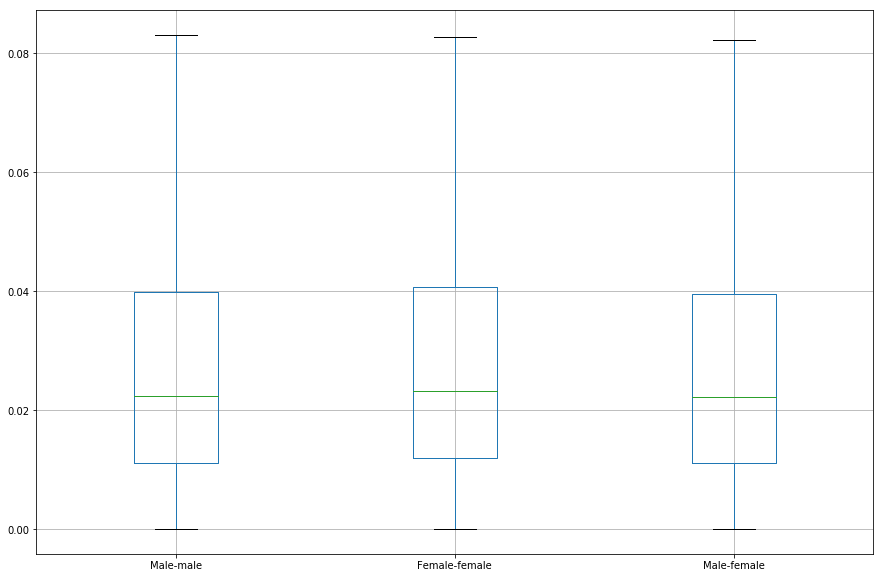

In [45]:
csbox = cs.boxplot(figsize = [15,10],showfliers = False)